<a href="https://colab.research.google.com/github/NourhanTamer20/Alzheimer-sDetection/blob/main/Detecting_Alzheimer's_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [ ]:
! gdown 1bumxxbZ2O1rOpn-Wixddf4iu3s1MPkRi
! unzip -q ./Dataset2.zip
# ! pip3 install autokeras on google colab

Downloading...
From: https://drive.google.com/uc?id=1bumxxbZ2O1rOpn-Wixddf4iu3s1MPkRi
To: /content/Dataset2.zip
100% 4.40M/4.40M [00:00<00:00, 137MB/s]


# Imports

In [ ]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D ,MaxPooling2D,Dense,Flatten,Input,Concatenate,Lambda
from tensorflow.keras.callbacks import EarlyStopping
from skimage import io, color, feature, filters, img_as_ubyte
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
import random

# Preprocess data and create pairs for Siamese Model

In [ ]:
images_array = []
labels = []
img_size = 128
data_dir = './Dataset2'
classes = os.listdir(data_dir)
for c in classes:
  images = os.listdir(os.path.join(data_dir,c))[:32]

  for i in images:
    image = Image.open(os.path.join(os.path.join(data_dir,c),i))
    image = image.convert('RGB')
    image = image.resize((img_size,img_size))
    image = np.array(image)/255
    images_array.append(image)
    labels.append(c)

In [ ]:
left = []
right = []
similarity = []
similarity_images = 4
for index_left in range(len(images_array)):
  for index_right in range(index_left+1,len(images_array)):
    left.append(images_array[index_left])
    right.append(images_array[index_right])
    similarity.append(int(labels[index_left] == labels[index_right]))
left = np.array(left)
right = np.array(right)
similarity = np.array(similarity,dtype=float)
one_hot_encoder = OneHotEncoder()
similarity = one_hot_encoder.fit_transform(similarity.reshape(-1,1)).toarray()

# Extract Image Features

In [ ]:
def get_image_feature(image):
  # Convert the image to grayscale
  gray_image = color.rgb2gray(image)
  gray_image = img_as_ubyte(color.rgb2gray(image))

  # Extract intensity-based features
  mean_intensity = np.mean(gray_image)
  std_intensity = np.std(gray_image)

  # Extract texture-based features using GLCM
  glcm = feature.greycomatrix(gray_image, [5], [0], symmetric=True, normed=True)
  contrast = feature.greycoprops(glcm, 'contrast')[0, 0]
  homogeneity = feature.greycoprops(glcm, 'homogeneity')[0, 0]

  # Extract gradient-based features
  grad_mag = filters.sobel(gray_image)
  grad_dir = np.arctan2(grad_mag[1], grad_mag[0])
  return np.array([mean_intensity,std_intensity,contrast,homogeneity])

In [ ]:
images_features_array = []
xg_labels = []

data_dir = './Dataset2'
classes = os.listdir(data_dir)
for c in classes:
  images = os.listdir(os.path.join(data_dir,c))

  for i in images:
    image = Image.open(os.path.join(os.path.join(data_dir,c),i))
    image = image.convert('RGB')
    images_features_array.append(get_image_feature(image))
    xg_labels.append(c)
xg_labels = [classes.index(l) for l  in xg_labels]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1

# Create Siamese Model

In [ ]:
X_l_train,X_l_test,X_r_train,X_r_test,y_train,y_test = train_test_split(left,right,similarity,test_size=0.2,random_state=42)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
input_layer = Input((img_size, img_size, 3))
layer1 = Conv2D(128, (3, 3), activation='tanh')(input_layer)
layer2 = MaxPooling2D((2, 2))(layer1)
layer3 = Conv2D(64, (3, 3), activation='tanh')(layer2)
layer4 = Conv2D(32, (3, 3), activation='tanh')(layer3)
layer5 = Conv2D(16, (3, 3), activation='tanh')(layer4)
layer6 = Flatten()(layer5)
layer7 = Dense(512, activation='tanh')(layer6)
layer8 = Dense(256, activation='tanh')(layer7)
layer9 = Dense(128, activation='tanh')(layer8)
layer10 = Dense(64, activation='tanh')(layer9)
layer11 = Dense(32, activation='tanh')(layer10)
layer12 = Dense(16, activation='tanh')(layer11)

# Create model
model = Model(inputs=input_layer, outputs=layer5)


# Create siamese model
input_left = Input((img_size,img_size,3))
input_right = Input((img_size,img_size,3))

# Create left and right twin models
left_model = model(input_left)
right_model = model(input_right)
concatenated = Lambda(euclidean_distance)([left_model, right_model])
s_layer1 = Dense(64, activation='tanh')(concatenated)
s_layer2 = Dense(32, activation='tanh')(s_layer1)
s_layer3 = Dense(16, activation='tanh')(s_layer2)
s_layer4 = Flatten()(s_layer3)
out = Dense(2, activation='softmax')(s_layer4)

model = Model([input_left, input_right], out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 57, 57, 16)   100464      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

# Train and Test Model

In [ ]:
opt = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss',
                  min_delta=0.01,
                  patience=3,
                  verbose=1, mode='auto')
model.compile(optimizer=opt, loss= 'binary_crossentropy', metrics=['accuracy'])

history= model.fit(x = [X_l_train,X_r_train],
                   y = y_train,
                   batch_size = 16,
                   verbose = 1,
                   callbacks = [es],
                   epochs = 50,
                   validation_data = ([[X_l_test,X_r_test]],y_test))

Epoch 1/50
101/101 [==============================] - 17s 68ms/step - loss: 0.6411 - accuracy: 0.6600 - val_loss: 0.6027 - val_accuracy: 0.6856
Epoch 2/50
101/101 [==============================] - 5s 50ms/step - loss: 0.5690 - accuracy: 0.7091 - val_loss: 0.5092 - val_accuracy: 0.7450
Epoch 3/50
101/101 [==============================] - 5s 49ms/step - loss: 0.4668 - accuracy: 0.7860 - val_loss: 0.4279 - val_accuracy: 0.7847
Epoch 4/50
101/101 [==============================] - 5s 47ms/step - loss: 0.3650 - accuracy: 0.8455 - val_loss: 0.3615 - val_accuracy: 0.8564
Epoch 5/50
101/101 [==============================] - 5s 51ms/step - loss: 0.2811 - accuracy: 0.8902 - val_loss: 0.2775 - val_accuracy: 0.8936
Epoch 6/50
101/101 [==============================] - 5s 49ms/step - loss: 0.1660 - accuracy: 0.9479 - val_loss: 0.1835 - val_accuracy: 0.9257
Epoch 7/50
101/101 [==============================] - 5s 50ms/step - loss: 0.0963 - accuracy: 0.9715 - val_loss: 0.0817 - val_accuracy: 0.970

In [ ]:
model.save('Siamese.h5')

# Testing Seamese Model Predictions

In [ ]:
def get_input_pairs(images_array,image):
  image_arr = []
  for i in range(len(images_array)):
    image_arr.append(image)
  return [np.asarray(images_array),np.asarray(image_arr)]

In [ ]:
def get_prediction(labels,images_array, image):
  input_pairs = get_input_pairs(images_array,image)
  similarity = one_hot_encoder.inverse_transform(model.predict([input_pairs[0],input_pairs[1]],verbose = 0))
  label = [j for i,j in zip(similarity,labels) if i==1]
  value_counts = pd.Series(label).value_counts()
  label = value_counts.idxmax()
  return label

In [ ]:
img_path = '/content/Dataset2/MildDemented/mild_37.jpg'

In [ ]:
image = Image.open(img_path)
image = image.convert('RGB')
image = image.resize((img_size,img_size))
image = np.array(image)/255
get_prediction(labels, images_array,image)

'MildDemented'

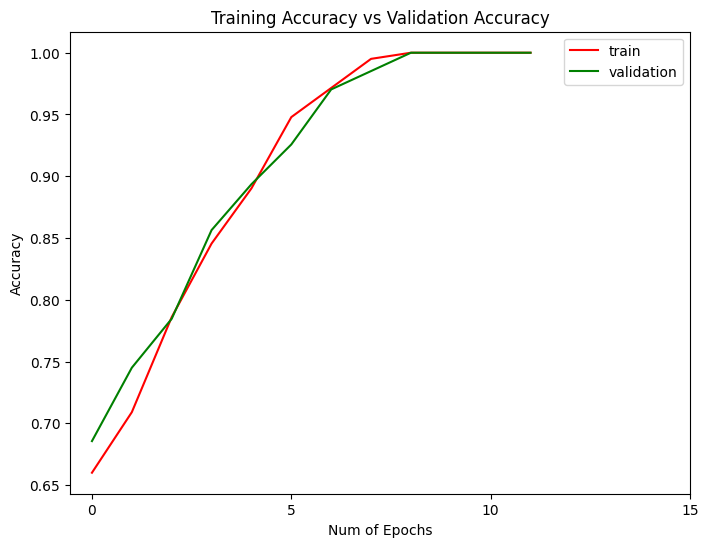

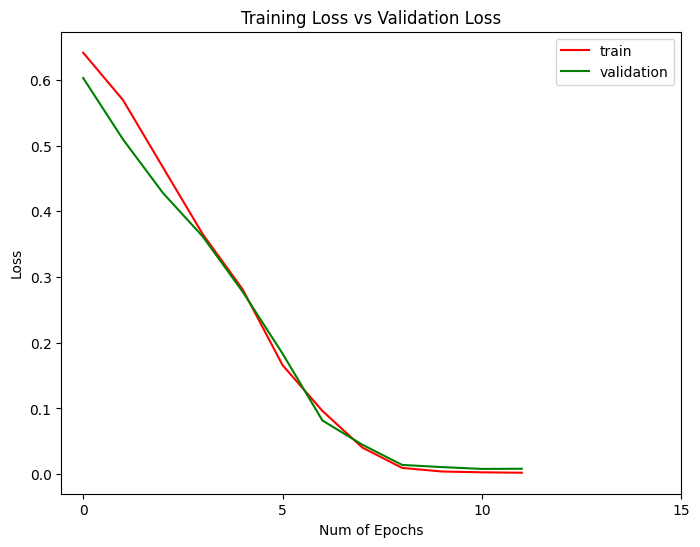

In [ ]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 20, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 20, 5.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

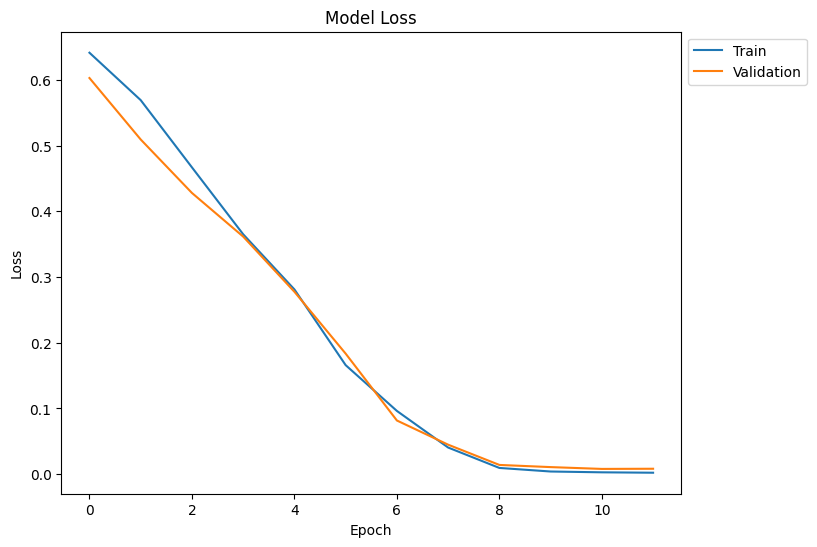

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()